In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
from sksurv.svm import FastKernelSurvivalSVM
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sksurv.metrics import concordance_index_censored, integrated_brier_score, brier_score
from lifelines.utils.sklearn_adapter import sklearn_adapter
from lifelines.utils import concordance_index
from scipy.stats import gumbel_r, norm, logistic
import lifelines.datasets as dset
import math
from sklearn.calibration import calibration_curve, CalibrationDisplay
from matplotlib.gridspec import GridSpec
import warnings
from scipy.special import erf
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
data_encoded = pd.read_csv('seer_encoded.csv', index=False)

In [ ]:
dataset = data_encoded.reset_index(drop=True)
N = dataset.shape[0]

time_column = 'time'
event_column = 'cod'
features = np.setdiff1d(dataset.columns, [time_column, event_column] ).tolist()

# Building training and testing sets
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split( range(N), test_size = 0.1, random_state = 142857, stratify = dataset[event_column])
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )
N2 = data_train.shape[0]

index_train, index_val = train_test_split( range(N2), test_size = 0.1, random_state = 142857, stratify = data_train[event_column])
data_train = dataset.loc[index_train].reset_index( drop = True )
data_val  = dataset.loc[index_val].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test, X_val = data_train[features], data_test[features], data_val[features]
time_train, time_test, time_val = data_train[time_column], data_test[time_column], data_val[time_column]
event_train, event_test, event_val = data_train[event_column], data_test[event_column], data_val[event_column]

step = 5
print(X_train.shape)
print(X_test.shape)

### RSF and CoxPH

In [ ]:
# RSF
from sksurv.ensemble import RandomSurvivalForest
bool_indicator_train =  [bool(x) for x in event_train]
y_train_tuple =  c = np.array(list(zip(bool_indicator_train, time_train)), dtype=[('a', bool), ('b', float)])
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=6, 
                            min_samples_leaf=3, n_jobs=16)
rsf.fit(X_train, y_train_tuple)
rsf_func = rsf.predict_survival_function(X_test)
# survprob_rsf= np.array(1-rsf.predict_survival_function(X_test, times = np.arange(time_test.min(),time_test.max(),step)).T)

In [ ]:
# CoxPH
from sksurv.linear_model import CoxPHSurvivalAnalysis
bool_indicator_train =  [bool(x) for x in event_train]
y_train_tuple =  c = np.array(list(zip(bool_indicator_train, time_train)), dtype=[('a', bool), ('b', float)])
CoxPH = CoxPHSurvivalAnalysis(alpha=0.1,verbose=0) # alpha=0 causes singular matrix error

CoxPH.fit(X_train, y_train_tuple)
coxph_func = CoxPH.predict_survival_function(X_test)

### PyCOX methods

In [ ]:
# DeepSurv
from pycox.models import CoxPH
import torchtuples as tt
import torch
# set default tensor type
# torch.set_default_tensor_type(torch.cuda.FloatTensor)
batch_size = 4096
epochs = 10000

y_train_tuple = (time_train.to_numpy().astype(np.float32), event_train.to_numpy().astype(np.float32))
y_val_tuple = (time_val.to_numpy().astype(np.float32), event_val.to_numpy().astype(np.float32))
val = X_val.to_numpy().astype(np.float32), y_val_tuple
in_features = X_train.shape[1]
num_nodes = [32, 32, 32]
out_features = 1
batch_norm = True
dropout = 0.0
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                            dropout, output_bias=output_bias)
deepsurv = CoxPH(net, tt.optim.Adam, device=torch.device("cuda"))
deepsurv.optimizer.set_lr(0.001)
callbacks = [tt.callbacks.EarlyStopping(patience=100)]
verbose = False
log = deepsurv.fit(X_train.to_numpy().astype(np.float32), y_train_tuple, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)
_ = deepsurv.compute_baseline_hazards()
deepsurv_pred = deepsurv.predict_surv_df(X_test.to_numpy().astype(np.float32))

In [ ]:
# CoxCC
from pycox.models import CoxCC
import torchtuples as tt
import torch
batch_size = 4096
epochs = 10000

y_train_tuple = (time_train.to_numpy().astype(np.float32), event_train.to_numpy().astype(np.float32))
y_val_tuple = (time_val.to_numpy().astype(np.float32), event_val.to_numpy().astype(np.float32))
val = X_val.to_numpy().astype(np.float32), y_val_tuple
in_features = X_train.shape[1]
num_nodes = [32, 32, 32]
out_features = 1
batch_norm = True
dropout = 0.0
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                            dropout, output_bias=output_bias)
coxcc = CoxCC(net, tt.optim.Adam, device=torch.device("cuda"))
coxcc.optimizer.set_lr(0.001)
callbacks = [tt.callbacks.EarlyStopping(patience=100)]
verbose = False
log = coxcc.fit(X_train.to_numpy().astype(np.float32), y_train_tuple, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)
_ = coxcc.compute_baseline_hazards()
coxcc_pred = coxcc.predict_surv_df(X_test.to_numpy().astype(np.float32))

In [ ]:
# DeepHit
from pycox.models import DeepHitSingle
import torchtuples as tt
import torch

num_durations = 250
batch_size = 4096*4
epochs = 10000

labtrans = DeepHitSingle.label_transform(num_durations)
y_train_tuple = labtrans.fit_transform(time_train.to_numpy().astype(np.float32), event_train.to_numpy().astype(np.float32))
y_val_tuple = labtrans.fit_transform(time_val.to_numpy().astype(np.float32), event_val.to_numpy().astype(np.float32))
val = X_val.to_numpy().astype(np.float32), y_val_tuple

in_features = X_train.shape[1]
num_nodes = [32, 32, 32]
out_features = num_durations
batch_norm = True
dropout = 0.0
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
deephit = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, 
                        duration_index=labtrans.cuts, device=torch.device("cuda"))
deephit.optimizer.set_lr(0.001)
callbacks = [tt.callbacks.EarlyStopping(patience=100)]
verbose = False
log = deephit.fit(X_train.to_numpy().astype(np.float32), y_train_tuple, batch_size, epochs, callbacks, verbose, val_data=val, val_batch_size=batch_size)
deephit_pred = deephit.predict_surv_df(X_test.to_numpy().astype(np.float32))

In [ ]:
from pycox.models import PCHazard
import torchtuples as tt
import torch

batch_size = 4096*4
epochs = 10000
num_durations = 250

labtrans = PCHazard.label_transform(num_durations)
y_train_tuple = labtrans.fit_transform(time_train.to_numpy().astype(np.float32), event_train.to_numpy().astype(np.float32))
y_val_tuple = labtrans.fit_transform(time_val.to_numpy().astype(np.float32), event_val.to_numpy().astype(np.float32))
val = X_val.to_numpy().astype(np.float32), y_val_tuple

in_features = X_train.shape[1]
num_nodes = [32, 32, 32]
out_features = labtrans.out_features
batch_norm = False
dropout = 0.0
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)                
pchazard = PCHazard(net, tt.optim.Adam, device=torch.device("cuda"))
pchazard.optimizer.set_lr(0.0001)
callbacks = [tt.callbacks.EarlyStopping(patience=200)]
verbose = False
log = pchazard.fit(X_train.to_numpy().astype(np.float32), y_train_tuple, batch_size, epochs, callbacks, verbose, val_data=val, val_batch_size=batch_size)
pchazard_pred = pchazard.predict_surv_df(X_test.to_numpy().astype(np.float32))

### DCSurvival

In [67]:
import os,sys
import torch
sys.path.append("../")
from dirac_phi import DiracPhi
from survival import SurvivalCopula_sumofull
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, TensorDataset

torch.set_num_threads(24)
torch.set_default_tensor_type(torch.DoubleTensor)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

load_previous = True
depth = 2
widths = [100, 100]
lc_w_range = (0, 1.0)
shift_w_range = (0., 2.0)
num_epochs = 100000
batch_size = 4096*4
early_stop_epochs = 500

times_tensor_train = torch.tensor(time_train.to_numpy(), dtype=torch.float64).to(device)
event_indicator_tensor_train = torch.tensor(event_train.to_numpy(), dtype=torch.float64).to(device)
covariate_tensor_train = torch.tensor(X_train.to_numpy(), dtype=torch.float64).to(device)

times_tensor_val = torch.tensor(time_val.to_numpy(), dtype=torch.float64).to(device)
event_indicator_tensor_val = torch.tensor(event_val.to_numpy(), dtype=torch.float64).to(device)
covariate_tensor_val = torch.tensor(X_val.to_numpy(), dtype=torch.float64).to(device)

dataset = TensorDataset(covariate_tensor_train, times_tensor_train, event_indicator_tensor_train)     
val_dataset = TensorDataset(covariate_tensor_val, 
                            times_tensor_val, event_indicator_tensor_val)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

phi = DiracPhi(depth, widths, lc_w_range, shift_w_range, device, tol = 1e-14).to(device)
dcs_model = SurvivalCopula_sumofull(phi, device = device, num_features=X_train.shape[1], 
                                tol=1e-14, hidden_size = 32)
dcs_model.to(device)

if load_previous == True:
    checkpoint = torch.load('/home/SurvivalACNet_sumo/checkpoints/weight.pth')
    dcs_model.load_state_dict(checkpoint['model_state_dict'])
optimizer = optim.AdamW([{"params": dcs_model.sumo_e.parameters(), "lr": 1e-6},
                        {"params": dcs_model.sumo_c.parameters(), "lr": 1e-6},
                        {"params": dcs_model.phi.parameters(), "lr": 1e-6}
                    ])
# Train the model
best_val_loglikelihood = float('-inf')
epochs_no_improve = 0 
for epoch in tqdm(range(num_epochs)):
# for epoch in range(num_epochs):
    optimizer.zero_grad()
    logloss = dcs_model(covariate_tensor_train, times_tensor_train, event_indicator_tensor_train, max_iter = 10000)
    (-logloss).backward() 
    optimizer.step()
    # for covariates, times, events in dataloader:  # iterate over batches 
    #     optimizer.zero_grad()
    #     logloss = dcs_model(covariates, times, events, max_iter = 10000)
    #     (-logloss).backward() 
    #     optimizer.step()
    if epoch % 100 == 0:
        val_loglikelihood = dcs_model(covariate_tensor_val, times_tensor_val, event_indicator_tensor_val, max_iter = 10000)
        print("epoch", epoch, "train likelihood", logloss.item(),"val likelihood", val_loglikelihood.item())
        if val_loglikelihood > (best_val_loglikelihood ):
            best_val_loglikelihood = val_loglikelihood
            epochs_no_improve = 0
            torch.save({'epoch': epoch, 'model_state_dict': dcs_model.state_dict(),'loss': best_val_loglikelihood,
                        }, '/home/SurvivalACNet_sumo/checkpoints/weight.pth')
        else:
            epochs_no_improve = epochs_no_improve + 100
    # Early stopping condition
    if epochs_no_improve == early_stop_epochs:
        # print('Early stopping triggered at epoch: %s' % epoch)
        break
# load the best model
checkpoint = torch.load('/home/SurvivalACNet_sumo/checkpoints/weight.pth')
dcs_model.load_state_dict(checkpoint['model_state_dict'])

  0%|          | 1/100000 [00:00<14:14:26,  1.95it/s]

epoch 0 train likelihood -87828.759893254 val likelihood -9881.502605947926


  0%|          | 101/100000 [00:26<7:42:02,  3.60it/s]

epoch 100 train likelihood -87826.98173203968 val likelihood -9881.489666461033


  0%|          | 201/100000 [00:51<7:40:53,  3.61it/s]

epoch 200 train likelihood -87825.12481102362 val likelihood -9881.485816262924


  0%|          | 301/100000 [01:17<7:41:02,  3.60it/s]

epoch 300 train likelihood -87823.24377675515 val likelihood -9881.483496927507


  0%|          | 401/100000 [01:43<7:59:07,  3.46it/s]

epoch 400 train likelihood -87821.35129673427 val likelihood -9881.485077811845


  1%|          | 501/100000 [02:09<7:18:12,  3.78it/s]

epoch 500 train likelihood -87819.45236999705 val likelihood -9881.49051327593


  1%|          | 601/100000 [02:34<7:56:07,  3.48it/s]

epoch 600 train likelihood -87817.5495112351 val likelihood -9881.499246644962


  1%|          | 701/100000 [03:01<7:52:33,  3.50it/s]

epoch 700 train likelihood -87815.64417670252 val likelihood -9881.51066564746


  1%|          | 800/100000 [03:27<7:09:47,  3.85it/s]

epoch 800 train likelihood -87813.73729202943 val likelihood -9881.524166527783


<All keys matched successfully>

In [ ]:
setp = 10

print(X_test.shape)
times = np.arange(time_test.min(),time_test.max(),step)

times_tensor = torch.tensor(times).to(device)
covariate_tensor_test = torch.tensor(X_test.to_numpy(), dtype=torch.float64).to(device)
survprob_matrix_list = []
for time in times_tensor:
    temp = 1- dcs_model.survival(time, covariate_tensor_test).cpu().detach().numpy()
    survprob_matrix_list.append(temp)
survprob_matrix = np.vstack(survprob_matrix_list)
survprob_dcsurvival = list(survprob_matrix.transpose())

survprob_rsf = []
for i in range(X_test.shape[0]):
    survprob_rsf.append(1- rsf_func[i](times))

survprob_coxph = []
for i in range(X_test.shape[0]):
    survprob_coxph.append(1- coxph_func[i](times))

prediction_timepoint = deepsurv_pred.index
survprob_deepsurv = []
for i in range(X_test.shape[0]):
    temp_list = []
    for time in prediction_timepoint:
        temp_list.append( 1- deepsurv_pred[i][time] )
    survprob_deepsurv.append(temp_list)

prediction_timepoint = coxcc_pred.index
survprob_coxcc = []
for i in range(X_test.shape[0]):
    temp_list = []
    for time in prediction_timepoint:
        temp_list.append( 1- coxcc_pred[i][time] )
    survprob_coxcc.append(temp_list)

prediction_timepoint = deephit_pred.index
survprob_deephit = []
for i in range(X_test.shape[0]):
    temp_list = []
    for time in prediction_timepoint:
        temp_list.append( 1- deephit_pred[i][time] )
    survprob_deephit.append(temp_list)

prediction_timepoint = pchazard_pred.index

survprob_pchazard = []
for i in range(X_test.shape[0]):
    temp_list = []
    for time in prediction_timepoint:
        temp_list.append( 1- pchazard_pred[i][time] )
    survprob_pchazard.append(temp_list)

### Plotting

In [69]:
# y_l is the event time
# prob_lifelines is the probability of event at time y_l (predicted)
y_l = []
prob_lifelines = []
prob_rsf = []
prob_coxph=[]
prob_deepsurv = []
prob_deephit = []
prob_pchazard = []
prob_coxcc = []
prob_dcsurvival = []
for j in range(len(survprob_coxph)): #
    k = 0
    for i in np.arange(time_test.min(),time_test.max(),step): # from min to max of test time, the number of steps
        if k < len(survprob_coxph[0]):
            # if i <= time_test[j]:
            #     print(j)
            #     y_l.append(0)
            # else:
            #     y_l.append(1)
            prob_rsf.append(survprob_rsf[j][k])
            prob_coxph.append(survprob_coxph[j][k])
            k+=1
        else: 
            break
for j in range(len(survprob_deepsurv)): #
    k = 0
    for i in np.arange(time_test.min(),time_test.max(),step): # from min to max of test time, the number of steps
        if k < len(survprob_deepsurv[0]):
            if i <= time_test[j]:
                y_l.append(0)
            else:
                y_l.append(1)
            prob_deepsurv.append(survprob_deepsurv[j][k])

            prob_coxcc.append(survprob_coxcc[j][k])
            prob_deephit.append(survprob_deephit[j][k])
            prob_pchazard.append(survprob_pchazard[j][k])
            prob_dcsurvival.append(survprob_dcsurvival[j][k])
            k+=1
        else: 
            break
             
y_l = np.array(y_l)
prob_lifelines = np.array(prob_lifelines)
prob_rsf = np.array(prob_rsf)
prob_coxph = np.array(prob_coxph)
prob_deepsurv = np.array(prob_deepsurv)
prob_deephit = np.array(prob_deephit)
prob_pchazard = np.array(prob_pchazard)
prob_coxcc = np.array(prob_coxcc)
prob_dcsurvival = np.array(prob_dcsurvival)

[]

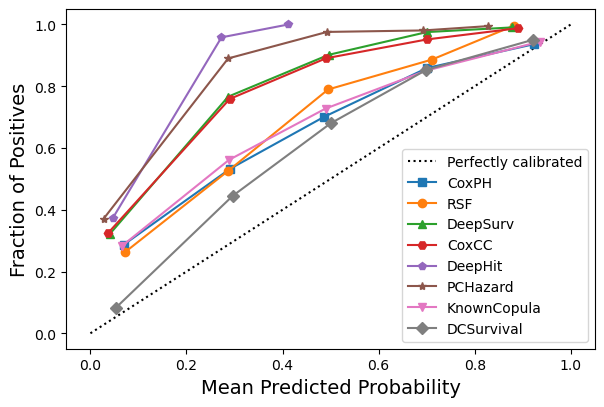

In [70]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 15))
gs = GridSpec(3, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:1, :1])
disp = CalibrationDisplay.from_predictions(y_l,prob_coxph, ax = ax_calibration_curve, name='CoxPH', marker='s')
disp = CalibrationDisplay.from_predictions(y_l,prob_rsf, ax = ax_calibration_curve, name='RSF', marker='o')
disp = CalibrationDisplay.from_predictions(y_l,prob_deepsurv, ax = ax_calibration_curve, name='DeepSurv', marker='^')
disp = CalibrationDisplay.from_predictions(y_l,prob_coxcc, ax = ax_calibration_curve, name='CoxCC', marker='H')


disp = CalibrationDisplay.from_predictions(y_l,prob_deephit, ax = ax_calibration_curve, name='DeepHit', marker='p')
disp = CalibrationDisplay.from_predictions(y_l,prob_pchazard, ax = ax_calibration_curve, name='PCHazard', marker='*')

disp = CalibrationDisplay.from_predictions(y_l,prob_dcsurvival, ax = ax_calibration_curve, name='DCSurvival', marker='D')


ax_calibration_curve.set_xlabel("Mean Predicted Probability", fontsize=14)
ax_calibration_curve.set_ylabel("Fraction of Positives", fontsize=14)
ax_calibration_curve.legend(fontsize=10)

# ax_calibration_curve.grid()
#ax_calibration_curve.set_title("DD")
ax_calibration_curve.plot()